In [2]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
using LinearAlgebra
using BlockDiagonals
using ControlSystems
using Plots

In [3]:
n = 0.0010831 #constant mean motion of the target
Nu = 3 #number of controls
Nx = 6 #number of states
n_frames = 10000 #Number of frames for running sim
thist = range(1,stop=n_frames, length=n_frames)

#Origin (Target Spacecraft)
r0 = [0.0, 0.0, 0.0]
v0 = [0.0, 0.0, 0.0]
x0 = [r0, v0]

#Initial Conditions
deltar = [15.0,20.0,15.0] # in km
deltav = [10.0,10.0,0.0] #in km

h=1 #timestep

1

In [4]:
#CW equations expressed in statespace form 
#Create A Matrix
A = Array{Float64, 2}(undef, 6, 6)
A[1:3,:] = [zeros(Float64,3,3) Matrix(I,3,3)]
A[4,:] = [3*n^2, 0,0,0,2*n,0]
A[5,:] = [0,0,0,(-2*n),0,0]
A[6,:] = [0,0,-n^2, 0,0,0]

#Create B Matrix
B = [zeros(Float64,3,3); Matrix(I,3,3)]

6×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [5]:
#Spacecraft Linear Dynamics
function spacecraft_dynamics(x,u)
    
    x_dot = A*x  +B*u
    
return x_dot
    
end

spacecraft_dynamics (generic function with 1 method)

In [6]:
#RK4 Integrator for sim
function spacecraft_dynamics_rk4(x,u)
    
    f1 = spacecraft_dynamics(x, u)
    f2 = spacecraft_dynamics(x + 0.5*h*f1, u)
    f3 = spacecraft_dynamics(x + 0.5*h*f2, u)
    f4 = spacecraft_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    return xn
end

spacecraft_dynamics_rk4 (generic function with 1 method)

In [7]:
# Cost weights
Q = Array(5*I(Nx)); #penalize the states
R = Array(5e10*I(Nu)); #penalize the controls

In [8]:
#change from continous to discrete 
H = exp(h*[A B; zeros(Nu,Nx+Nu)]) 

Ad = H[1:Nx, 1:Nx] 
Bd = H[1:Nx,(Nx+1):end]
 
#Obtain K matrix for optimal control law
K = dlqr(Ad,Bd,Q,R)

3×6 Matrix{Float64}:
 1.27419e-5  -4.88081e-6  0.0         0.00495878   0.000196441  0.0
 5.17425e-6   8.70353e-6  0.0         0.000191483  0.00426719   0.0
 0.0          0.0         8.87426e-6  0.0          0.0          0.0042135

In [9]:
#Controlability Matrix
C = Bd
for k = 1:(Nx-1)
    C = [C Ad*C[:,end-(Nu-1):end]]
end

In [10]:
rank(C)

6

In [11]:
#Feedback controller
function controller(x)
    deltax = [x[1:3]-r0;x[4:6]-v0]
    
    u = -K*deltax
    
end 

controller (generic function with 1 method)

In [12]:
#Simulation
uhist=zeros(Nu,n_frames)
xhist=zeros(Nx,n_frames)

#Initial state of the chaser is a fixed distance away from the target
perturbed = vcat(deltar, deltav)
xhist[:,1] = perturbed

6-element Vector{Float64}:
 15.0
 20.0
 15.0
 10.0
 10.0
  0.0

In [13]:
for k = 1:(n_frames-1)
    uhist[:,k] = controller(xhist[:,k])
    xhist[:,k+1] = spacecraft_dynamics_rk4(xhist[:,k],uhist[:,k])
end
print("final x value: ", last(xhist[1,:]))
print("final y value: ", last(xhist[2,:]))
print("final z value: ", last(xhist[3,:]))

final x value: -3.715415697799375e-8final y value: 2.410604560776788e-7final z value: -7.67846737174248e-9

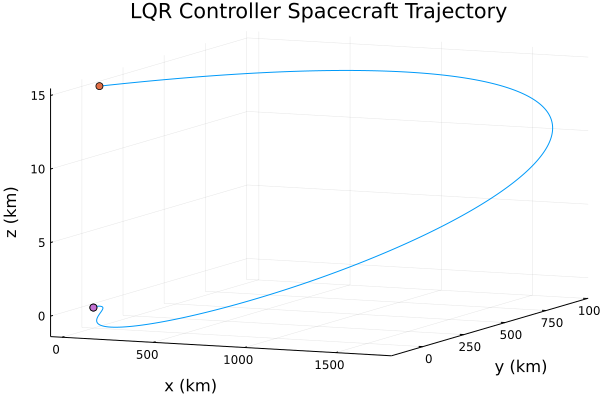

In [14]:
Plots.plot(xhist[1,:],xhist[2,:],xhist[3,:], title="LQR Controller Spacecraft Trajectory",xaxis="x (km)", yaxis="y (km)",zaxis="z (km)", legend=false)
Plots.scatter!([xhist[1,1]],[xhist[2,1]],[xhist[3,1]])
Plots.scatter!([0],[0],[0])
Plots.scatter!([last(xhist[1,:])],[last(xhist[2,:])],[last(xhist[3,:])])

In [15]:
print(size(xhist'))

(10000, 6)

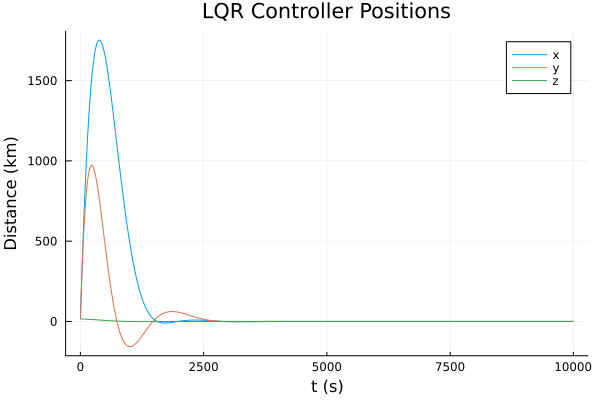

In [16]:
Plots.plot(xhist'[:,1:3], title="LQR Controller Positions", xaxis="t (s)", yaxis = "Distance (km)", labels=["x" "y" "z"])

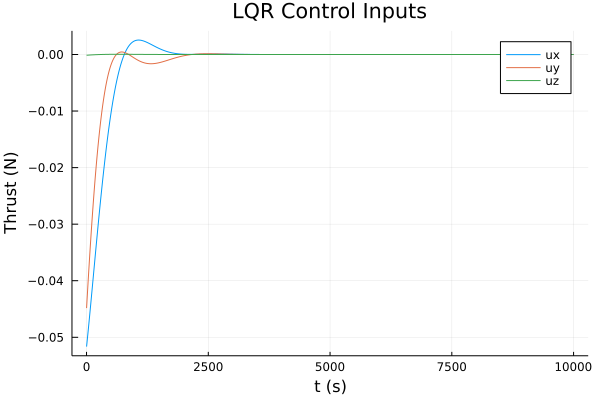

In [17]:
Plots.plot(uhist', title="LQR Control Inputs", xaxis="t (s)", yaxis = "Thrust (N)", labels=["ux" "uy" "uz"])

In [18]:
#total fuel used
print("total fuel", sum(uhist'))

total fuel-24.530974751093403

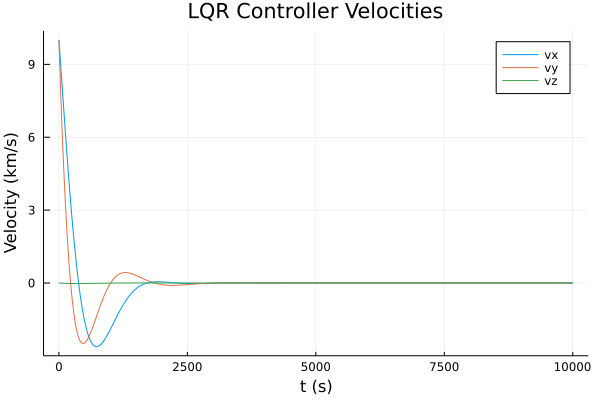

In [19]:
Plots.plot(xhist'[:,4:6], title="LQR Controller Velocities", xaxis="t (s)", yaxis = "Velocity (km/s)", labels=["vx" "vy" "vz"])

In [22]:
print(sum(uhist[:, 1:2500]))

-24.6261099957455

In [21]:
print(size(xhist))

(6, 10000)